In [14]:
import nd2
import numpy as np
import napari
from skimage.measure import label
import matplotlib.pyplot as plt

In [15]:
img = nd2.imread('./raw_data/240515_40x_cameraAlignment_largerGreen - Denoised_registered.nd2')

In [16]:
img.shape

(2, 2720, 2720)

In [17]:
ch_0 = img[0,:,:]
ch_1 = img[1,:,:]

In [18]:
threshold_ch0 = 1200
ch_0_mask = ch_0 > threshold_ch0

threshold_ch1 = 220
ch_1_mask = ch_1 > threshold_ch1

In [19]:
# Transform mask into objects using connected component analysis
ch_0_labels = label(ch_0_mask)
ch_1_labels = label(ch_1_mask)

In [31]:
viewer = napari.Viewer(ndisplay=2)
viewer.add_image(ch_0)
viewer.add_labels(ch_0_labels)
viewer.add_image(ch_1)
viewer.add_labels(ch_1_labels)

<Labels layer 'ch_1_labels' at 0x1fdef6d1a90>

In [ ]:
def calculate_positive_pixels(ch_0_labels, ch_1_labels):
    # Ensure that the input arrays have the same shape
    assert ch_0_labels.shape == ch_1_labels.shape, "Input arrays must have the same shape"

    # Ensure that both channels have the same number of labels
    assert np.max(ch_0_labels) == np.max(ch_1_labels), "Input arrays must have the same number of labels"
    
    # Count positive pixels in both channels
    positive_both = (ch_0_labels > 0) & (ch_1_labels > 0)
    
    # Count pixels for each label 
    label_counts = np.zeros(np.max(ch_0_labels))
    for label in range(1, (np.max(ch_0_labels) + 1)):
        label_counts[label - 1] = np.sum((ch_0_labels == label) & positive_both)
    # Calculate the percentage of positive pixels for both labels
    total_label_counts = np.array([np.sum(ch_0_labels == label) for label in range(1, (np.max(ch_0_labels) + 1))])
    percentage_positive_both = (label_counts / total_label_counts) * 100
    
    return label_counts, percentage_positive_both

# Example usage
label_counts, percentage_positive_both = calculate_positive_pixels(ch_0_labels, ch_1_labels)


In [33]:
# Ensure that the input arrays have the same shape
assert ch_0_labels.shape == ch_1_labels.shape, "Input arrays must have the same shape"

# Ensure that both channels have the same number of labels
assert np.max(ch_0_labels) == np.max(ch_1_labels), "Input arrays must have the same number of labels"

# Define the max number of labels
label_nr = np.max(ch_0_labels)

# Create an array that stores a True value for each of the xy positions where both ch_0 and ch_1 labels are present
positive_both = (ch_0_labels > 0) & (ch_1_labels > 0)

# Count positive pixels for each label in ch_0

# Initialize an empty array to store results 
label_counts = np.zeros(label_nr) 

# Loop over each label
for label in range(1, (label_nr + 1)):
    # Update the label_counts array with the sum of pixels for each ch0 labelled pixel that is also present in ch1 (positive both)
    label_counts[label - 1] = np.sum((ch_0_labels == label) & positive_both)

# Calculate the total number of pixels for each label in ch_0_labels
total_label_counts = np.array([np.sum(ch_0_labels == label) for label in range(1, (label_nr + 1))])
# Calculate the percentage of positive pixels for both labels
percentage_positive_both = (label_counts / total_label_counts) * 100

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81


In [32]:
label_counts.shape

(81,)

In [22]:
def plot_percentage_on_image(ch_0_labels, percentage_positive_both):
    plt.figure(figsize=(10, 10))
    plt.imshow(ch_0_labels, cmap='gray')
    
    for label in range(1, np.max(ch_0_labels) + 1):
        positions = np.column_stack(np.where(ch_0_labels == label))
        if len(positions) > 0:
            # Choose the first position found for each label to display the percentage
            y, x = positions[0]
            plt.text(x, y - 2, f'{percentage_positive_both[label - 1]:.2f}%', color='red', fontsize=8, ha='center')

    plt.title('Percentage of Positive Pixels for Both Labels')
    plt.axis('off')
    plt.show()


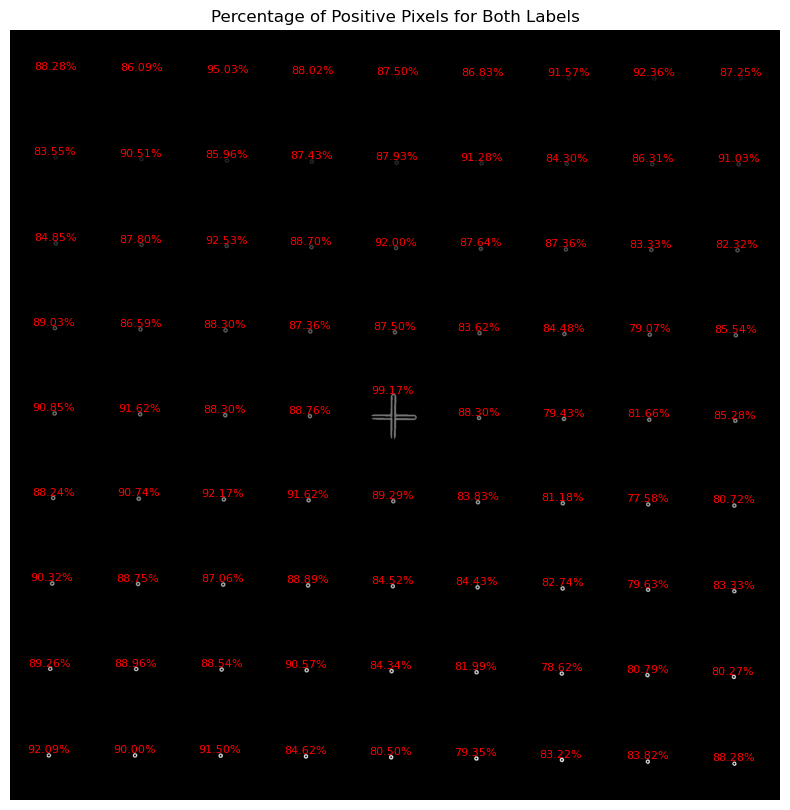

In [23]:
plot_percentage_on_image(ch_0_labels, percentage_positive_both)

In [24]:
label_counts[36]

3824.0